### Deliverable 1: Preprocessing the Data for a Neural Network

In [5]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving charity_data.csv to charity_data (1).csv
User uploaded file "charity_data.csv" with length 3605168 bytes


In [6]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#  Import and read the charity_data.csv.
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [7]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN','NAME'])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [8]:
# Generate our categorical variable list
vars = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

# Determine the number of unique values in each column.
application_df[vars].nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [9]:
# Look at APPLICATION_TYPE value counts for binning
counts = application_df.APPLICATION_TYPE.value_counts()
counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

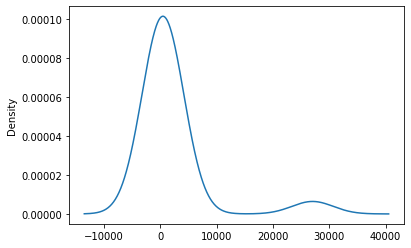

In [10]:
# Visualize the value counts of APPLICATION_TYPE
counts.plot(kind='density')
plt.show()

In [11]:
# Determine which values to replace if counts are less than 250?
replace_application = [i for i in dict(counts) if dict(counts)[i] < 250]

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [12]:
# Look at CLASSIFICATION value counts for binning
classes = application_df.CLASSIFICATION.value_counts()
classes

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C3700        1
C1245        1
C2380        1
C5200        1
C4200        1
Name: CLASSIFICATION, Length: 71, dtype: int64

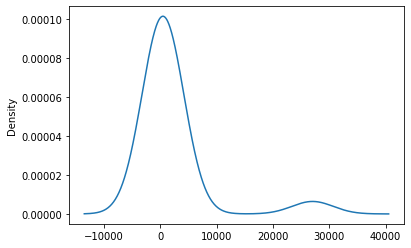

In [13]:
# Visualize the value counts of CLASSIFICATION
counts.plot(kind='density')
plt.show()

In [14]:
# Determine which values to replace if counts are less than ..?
replace_class = [i for i in dict(classes) if dict(classes)[i] < 1000]

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [15]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

In [16]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True).drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
application_df.shape

(34299, 44)

In [19]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop("IS_SUCCESSFUL",1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [20]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 352       
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [81]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
797/804 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.6589
Epoch 00001: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.6387 - accuracy: 0.6595
Epoch 2/100
795/804 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.7243
Epoch 00002: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5678 - accuracy: 0.7243
Epoch 3/100
800/804 [============================>.] - ETA: 0s - loss: 0.5575 - accuracy: 0.7273
Epoch 00003: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5573 - accuracy: 0.7275
Epoch 4/100
801/804 [============================>.] - ETA: 0s - loss: 0.5543 - accuracy: 0.7288
Epoch 00004: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5544 - accuracy: 0.7287
Epoch 5/100
797/804 [=======

In [82]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn_new = tf.keras.models.Sequential()

# First hidden layer
nn_new.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_new.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_new.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
nn_new.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Restore the model weights
nn_new.load_weights("checkpoints/weights.100.hdf5")

# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5545 - accuracy: 0.7251 - 553ms/epoch - 2ms/step
Loss: 0.5545250773429871, Accuracy: 0.7251312136650085


In [83]:
# Export our model to HDF5 file
nn_new.save("AlphabetSoupCharity.h5")

In [84]:
# Import the model to a new object
nn_imported = tf.keras.models.load_model('AlphabetSoupCharity.h5')

In [85]:
# Evaluate the completed model using the test data
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5545 - accuracy: 0.7251 - 518ms/epoch - 2ms/step
Loss: 0.5545250773429871, Accuracy: 0.7251312136650085


In [86]:
from google.colab import files
files.download('AlphabetSoupCharity.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
# EDIT 1 (1 input, 2 hidden, 1 output)
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu"))
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
801/804 [============================>.] - ETA: 0s - loss: 0.6321 - accuracy: 0.6826
Epoch 00001: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.6321 - accuracy: 0.6825
Epoch 2/100
780/804 [============================>.] - ETA: 0s - loss: 0.5655 - accuracy: 0.7263
Epoch 00002: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5655 - accuracy: 0.7262
Epoch 3/100
787/804 [============================>.] - ETA: 0s - loss: 0.5584 - accuracy: 0.7303
Epoch 00003: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5585 - accuracy: 0.7299
Epoch 4/100
785/804 [============================>.] - ETA: 0s - loss: 0.5564 - accuracy: 0.7312
Epoch 00004: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5559 - accuracy: 0.7318
Epoch 5/100
797/804 [=======

In [94]:
# EDIT 2 (number of nuerons 10,5 and 50 epochs)
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
791/804 [============================>.] - ETA: 0s - loss: 0.6020 - accuracy: 0.6922
Epoch 00001: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.6014 - accuracy: 0.6929
Epoch 2/50
804/804 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7262
Epoch 00002: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5659 - accuracy: 0.7262
Epoch 3/50
784/804 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.7280
Epoch 00003: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5615 - accuracy: 0.7282
Epoch 4/50
791/804 [============================>.] - ETA: 0s - loss: 0.5597 - accuracy: 0.7279
Epoch 00004: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5596 - accuracy: 0.7280
Epoch 5/50
789/804 [============

In [95]:
# EDIT 3 (number of nuerons 24,12 and 50 epochs)
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
776/804 [===========================>..] - ETA: 0s - loss: 0.5839 - accuracy: 0.7127
Epoch 00001: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5828 - accuracy: 0.7135
Epoch 2/50
794/804 [============================>.] - ETA: 0s - loss: 0.5574 - accuracy: 0.7287
Epoch 00002: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5574 - accuracy: 0.7286
Epoch 3/50
786/804 [============================>.] - ETA: 0s - loss: 0.5541 - accuracy: 0.7305
Epoch 00003: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5541 - accuracy: 0.7302
Epoch 4/50
777/804 [===========================>..] - ETA: 0s - loss: 0.5535 - accuracy: 0.7304
Epoch 00004: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.7310
Epoch 5/50
794/804 [============

In [111]:
# EDIT 4 (relu, sigmoid, sigmoid and 5 epochs)
number_input_features = len(X_train_scaled[0])
layer1 = 24
layer2 = 12

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=layer1, input_dim=number_input_features, activation="selu"))
nn.add(tf.keras.layers.Dense(units=layer2, activation="relu"))
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

fit_model = nn.fit(X_train_scaled,y_train,epochs=5,callbacks=[cp_callback])

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/5
802/804 [============================>.] - ETA: 0s - loss: 0.5857 - accuracy: 0.7107
Epoch 00001: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5857 - accuracy: 0.7107
Epoch 2/5
786/804 [============================>.] - ETA: 0s - loss: 0.5621 - accuracy: 0.7257
Epoch 00002: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5610 - accuracy: 0.7269
Epoch 3/5
788/804 [============================>.] - ETA: 0s - loss: 0.5573 - accuracy: 0.7282
Epoch 00003: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5574 - accuracy: 0.7285
Epoch 4/5
804/804 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.7305
Epoch 00004: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5552 - accuracy: 0.7305
Epoch 5/5
797/804 [=================

In [23]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=43))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [114]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.3 MB/s 


In [24]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [27]:
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 21, 'num_layers': 3, 'units_0': 11, 'units_1': 16, 'units_2': 26, 'units_3': 16, 'units_4': 16, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 26, 'num_layers': 1, 'units_0': 21, 'units_1': 16, 'units_2': 1, 'units_3': 11, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 26, 'num_layers': 1, 'units_0': 16, 'units_1': 6, 'units_2': 26, 'units_3': 26, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '008956c3040f1f06b707a6e7320ef2f7'}


In [29]:
# Evaluate the top three models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5523 - accuracy: 0.7293 - 562ms/epoch - 2ms/step
Loss: 0.5522774457931519, Accuracy: 0.7293294668197632
268/268 - 1s - loss: 0.5561 - accuracy: 0.7278 - 512ms/epoch - 2ms/step
Loss: 0.5561497211456299, Accuracy: 0.7278134226799011
268/268 - 0s - loss: 0.5529 - accuracy: 0.7273 - 490ms/epoch - 2ms/step
Loss: 0.5529369115829468, Accuracy: 0.7273469567298889
